# Analysis of Model Attention via Saliency Maps on VibroNet Mel-Spectrograms

The purpose of this notebook is to analyze which parts of the mel-spectrogram the VibroNet model relies on for predictions. We compute gradient-based saliency maps for individual audio samples and a dataset-level mean saliency map to identify global patterns of model attention. 

In [1]:
import sys
import os
from pathlib import Path

sys.path.append(os.path.abspath(".."))
sys.path.append(str(Path("..") / "src"))

import torch
from utils.config_manager import load_config
from data import create_data_loaders
from training import VibroNet

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = load_config()
config["data"]["augment"] = False

In [3]:
_, _, test_loader, dataset = create_data_loaders(config)

Total samples: 5265
Total unique audio files: 421
Split results:
  Train files: 268 -> 3340 slices
  Val files: 68 -> 854 slices
  Test files: 85 -> 1071 slices


In [4]:
mode = config["model"].get("type", "classification")
model = VibroNet(
    mode=mode,
    num_classes=config["model"]["num_classes"]
).to(device)

In [6]:
model_path = os.path.join("..", config["training"]["model_save_path"])

checkpoint = torch.load(
    model_path,
    map_location=device
)

model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

C:\Users\sokol\AppData\Local\Temp\ipykernel_25044\1754069402.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(


VibroNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [7]:
batch = next(iter(test_loader))
spectrograms, labels = batch

spectrogram = spectrograms[0].to(device)
label = labels[0]

## Single sample saliency

Based on one spectogram.

In [8]:
def saliency_map(model, spectrogram):
    model.eval()
    x = spectrogram.unsqueeze(0).requires_grad_(True)

    output = model(x)
    pred = output.argmax(dim=1)

    output[0, pred].backward()

    saliency = x.grad.abs().mean(dim=1).squeeze()
    return saliency.detach().cpu().numpy()

In [9]:
sal = saliency_map(model, spectrogram)

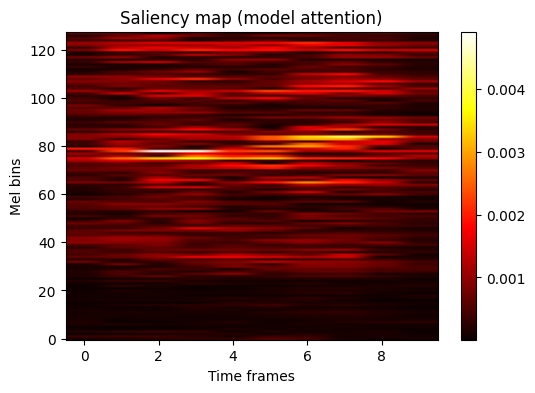

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.imshow(sal, aspect="auto", origin="lower", cmap="hot")
plt.title("Saliency map (model attention)")
plt.xlabel("Time frames")
plt.ylabel("Mel bins")
plt.colorbar()
plt.show()

### Saliency map computation
A gradient-based saliency map was computed to identify which time–frequency regions of the mel-spectrogram most strongly influence the model’s prediction. The saliency map is obtained by computing the absolute gradient of the model output with respect to the input spectrogram and averaging across channels.

The resulting map highlights regions where small input perturbations would cause the largest change in the model output.

The highest saliency values (up to approximately 0.004) are concentrated in higher mel frequency bins (around 80 mel bins), while lower-frequency regions exhibit substantially lower saliency.

This indicates that the model predominantly relies on high-frequency spectral components when making predictions. Lower-frequency mel bands contribute less to the decision process, suggesting that fine-grained, high-frequency patterns are more informative for the regression task.

## Mean Saliency

Based on 67 spectograms.

In [12]:
import numpy as np

all_sal = []

for spectrograms, _ in test_loader:
    spectrogram = spectrograms[0].to(device)
    sal = saliency_map(model, spectrogram)
    all_sal.append(sal)

mean_sal = np.mean(all_sal, axis=0)

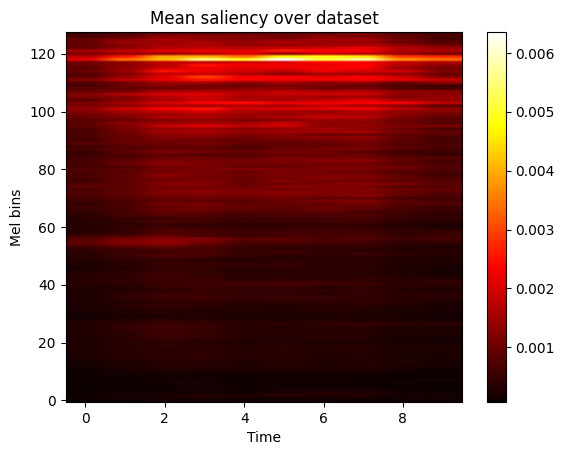

In [13]:
plt.imshow(mean_sal, aspect="auto", origin="lower", cmap="hot")
plt.title("Mean saliency over dataset")
plt.xlabel("Time")
plt.ylabel("Mel bins")
plt.colorbar()
plt.show()

Analysis of the mean saliency map across the dataset confirms the same pattern observed in individual samples: low-frequency mel bins consistently exhibit low saliency (dark on the heatmap), while high-frequency bins show a bright yellow-white band. This indicates that the model consistently relies on high-frequency spectral components for its predictions, not just in single instances but across the entire dataset.